In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from zipfile import ZipFile
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
filePath = '/content/drive/My Drive/AIML/Face_Recognition/Face_Recognization/'

In [5]:
with ZipFile(filePath+'Aligned_Face_Dataset_from_Pinterest.zip') as zipObj:
  zipObj.extractall()

In [6]:
pinsPath = './PINS/'
weightsPath  = 'vgg_face_weights.h5'

In [7]:
class IdentifyImage():
  def __init__(self,base,name,fileName):
    self.base = base
    self.name = name
    self.fileName = fileName
    
  def imagePath(self):
     return os.path.join(self.base, self.name, self.fileName)

In [8]:
def loadImagesFromFolder(folderName):
  metaData = []
  for pinFolderName in os.listdir(folderName):
    for imageName in os.listdir(f'{folderName}{pinFolderName}'):
      if imageName.endswith('.jpg') or imageName.endswith('.jpeg'):
        identifyImg = IdentifyImage(folderName,pinFolderName,imageName)
        # print(identifyImg.imagePath())
        metaData.append(identifyImg)
        # print('X')
        # break
  return metaData

In [9]:
metadata = np.array(loadImagesFromFolder(pinsPath))

In [10]:
imgae_width = 224
image_height = 224
channel = 3

In [11]:
def load_image(path):
  img = cv2.imread(path)
  # img = cv2.resize(img,(image_height,imgae_width))
  return img[...,::-1]

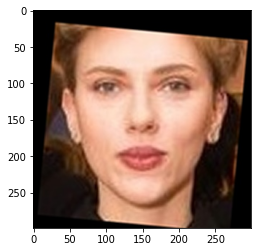

In [12]:
# plotting image from metaData array.
identifyImgObj = metadata[0]
imagePath = identifyImgObj.imagePath()
img = load_image(imagePath)
plt.imshow(img)

In [13]:
# VGG Face model

In [14]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D,BatchNormalization,Dropout,Activation, MaxPooling2D,Flatten,ZeroPadding2D

In [15]:
def prepare_VGG_Model(inputShape):
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))

  return model

In [16]:
input_shape = (224,224,3)

In [17]:
model = prepare_VGG_Model(input_shape)


In [18]:
model.load_weights(filePath+weightsPath)


In [19]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [20]:
vgg_face_descriptor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)     

150528
(224, 224, 3)
(2622,)


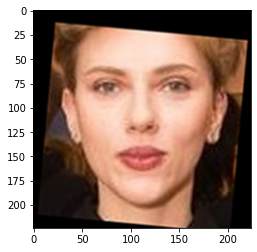

In [21]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].imagePath()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (image_height,imgae_width))
plt.imshow(img)
print(img.size)
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

In [22]:
embeddings = np.zeros((metadata.shape[0], 2622))

for index,obj in tqdm(enumerate(metadata)):
  imgPath = obj.imagePath()
  im = load_image(imgPath)
  im = (im / 255.0).astype(np.float32)
  im = cv2.resize(im,dsize=(image_height,imgae_width))

  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  embeddings[index] = embedding_vector
  

10770it [29:26,  6.10it/s]


In [35]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

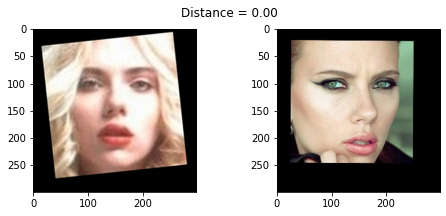

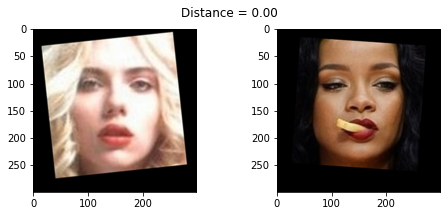

In [36]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].imagePath()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].imagePath()));    

show_pair(2, 3)
show_pair(2, 180)

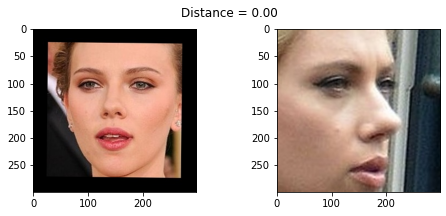

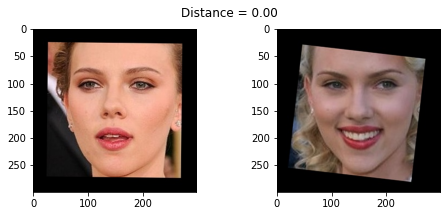

In [37]:
show_pair(30, 31)
show_pair(30, 100)

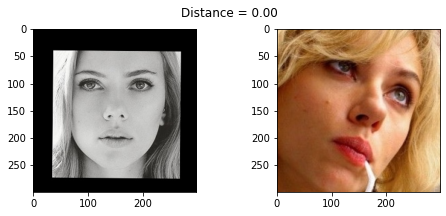

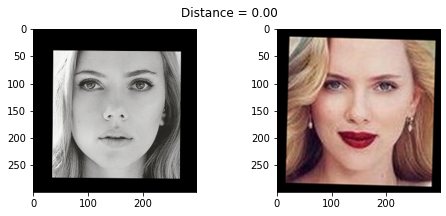

In [26]:
show_pair(70, 72)
show_pair(70, 115)

In [38]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities

X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [39]:
X_test[0].shape

(2622,)

In [40]:
y_test

array(['pins_Scarlett Johansson', 'pins_Scarlett Johansson',
       'pins_Scarlett Johansson', ..., 'pins_Henry Cavil',
       'pins_Henry Cavil', 'pins_Henry Cavil'], dtype='<U29')

In [41]:
from sklearn.preprocessing import LabelEncoder

In [42]:
le = LabelEncoder()
y_test_le = le.fit_transform(y_test)
y_train_le = le.fit_transform(y_train)

In [43]:
y_test_le

array([52, 52, 52, ..., 24, 24, 24])

In [45]:
# from sklearn.decomposition import PCA

# train_pca = PCA(n_components=128)
# X_train_pca = train_pca.fit_transform(X_train)

# test_pca = PCA(n_components=128)
# X_test_pca = train_pca.fit_transform(X_test)

In [46]:
# X_train.shape, X_train_pca.shape

In [47]:
# X_test.shape, X_test_pca.shape

In [48]:
# from sklearn.svm import SVC

# svc_clf = SVC()
# svc_clf.fit(X_train_pca,y_train_le)

In [49]:
# svc_clf.predict(X_test_pca)

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC

steps = [('PCA',PCA(n_components=128)),('SVC',SVC(C=0.1,gamma='auto'))]
pipeline_model = Pipeline(steps=steps)
pipeline_model.fit(X_train,y_train_le)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=128,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('SVC',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [57]:
y_pred = pipeline_model.predict(X_test)
y_pred

array([76, 76, 76, ..., 76, 76, 76])

(1, 2622)


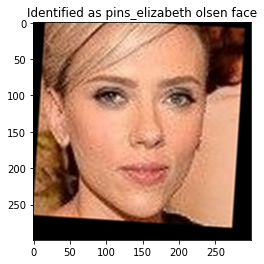

In [65]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].imagePath())

scaled_image = (example_image / 255.0).astype(np.float32)
im = cv2.resize(scaled_image,dsize=(image_height,imgae_width))

embedding_vector_result = vgg_face_descriptor.predict(np.expand_dims(im, axis=0))[0].reshape(1,-1)
print(embedding_vector_result.shape)

example_prediction = pipeline_model.predict(embedding_vector_result)
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');